# Image Classification
In this project, you'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers.  At the end, you'll get to see your neural network's predictions on the sample images.
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

Ask yourself "What are all possible labels?", "What is the range of values for the image data?", "Are the labels in order or random?".  Answers to questions like these will help you preprocess the data and end up with better predictions.


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


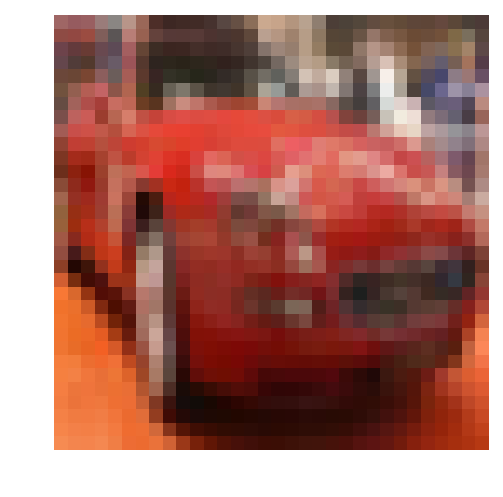

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np
import pandas as pd

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [31]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    normalized_x = np.zeros(tuple(x.shape))
    nr_images = x.shape[0]
    # Compute max/min values.
    max_val, min_val = x.max(), x.min()
    # Transform every image.
    for image_index in range(nr_images):
        normalized_x[image_index,...] = (x[image_index, ...] - float(min_val)) / float(max_val - min_val)    
    return normalized_x

tests.test_normalize(normalize)

Tests Passed


### One-hot encode
This time, we'll implement the `one_hot_encode` function. The input, `x`, are a list of labels.  Implement the function to return the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`. Here we will use the `LabelBinarizer` function from `sklearn.preprocessing` 

In [71]:
a=np.arange(10)
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    from sklearn.preprocessing import LabelBinarizer
    en=LabelBinarizer()
    en=en.fit(a)
    return en.transform(x)


tests.test_one_hot_encode(one_hot_encode)

Tests Passed


## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [72]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
The preprocessed data has been saved to disk. From now on we can start the program from the below cell , so that we don't have to run the above cells each time .

In [73]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, we'll build each layer into a function. This isn't necessary but we have done it, as it helps us understanding how each layer works and it would be easy to understand in next time we see our project. 

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. Implement the following functions
* Implement `neural_net_image_input`
 * Return a [TF Placeholder]
* Implement `neural_net_label_input`
 * Return a [TF Placeholder]
* Implement `neural_net_keep_prob_input`
 * Return a [TF Placeholder]

In [74]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    # Implement Function
    a=((None,image_shape[0],image_shape[1],image_shape[2]))
    return tf.compat.v1.placeholder(tf.float32, shape=a, name='x')


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # Implement Function
    n_classes= (None, n_classes) 
    return tf.compat.v1.placeholder(tf.float32, shape=n_classes , name='y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # Implement Function
    return tf.compat.v1.placeholder(tf.float32, name='keep_prob')

tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, you should implement the function `conv2d_maxpool` to apply convolution then max pooling:

In [75]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # TODO: Implement Function
    weights_shape = list(conv_ksize) + [x_tensor.get_shape().as_list()[3], conv_num_outputs]
    # Define our trainable variables.
    weights = tf.Variable(tf.truncated_normal(weights_shape, stddev=5e-2))
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    
    output = tf.nn.conv2d(x_tensor, weights, strides=[1, conv_strides[0], conv_strides[1], 1], padding='SAME')
    output = tf.nn.bias_add(output, bias)
    output = tf.nn.relu(output)
    
    output = tf.nn.max_pool(output, 
                            ksize=[1, pool_ksize[0], pool_ksize[1], 1], 
                            strides=[1, pool_strides[0], pool_strides[1], 1],
                            padding='SAME')  
    
    return output

tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer
Implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*).

In [76]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # Implement Function
    y=tf.compat.v1.layers.flatten(x_tensor)
    return y

tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer
Implement the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). 

In [77]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    y=tf.contrib.layers.fully_connected(x_tensor,num_outputs)
    return y


tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer
Implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). 

In [78]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    y=tf.contrib.layers.fully_connected(x_tensor,num_outputs)
    return y

tests.test_output(output)

Tests Passed


### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  Use the layers you created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply TensorFlow's Dropout to one or more layers in the model using `keep_prob`. 

In [102]:
def conv_net(x, keep_prob,num_classes=10):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # Apply 1, 2, or 3 Convolution and Max Pool layers
    conv = conv2d_maxpool(x,conv_num_outputs =64 ,
                          conv_ksize = [5,5], 
                          conv_strides = [1,1], 
                          pool_ksize = [3,3], 
                          pool_strides = [2,2])
    
    conv = conv2d_maxpool(x,conv_num_outputs =64 ,
                          conv_ksize = [5,5], 
                          conv_strides = [1,1], 
                          pool_ksize = [3,3], 
                          pool_strides = [2,2])
    

    # Apply a Flatten Layer
    flat = flatten(conv)

    # Apply 1, 2, or 3 Fully Connected Layers
    full = fully_conn(flat,384)
    full = fully_conn(flat,200)
    
    #  Apply an Output Layer
    full = tf.nn.dropout(full,keep_prob)
    full = output(full,num_classes)
    
    
    # return output
    return full


### Build the Neural Network ###


# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

In [103]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # Implement Function
    session.run(optimizer , feed_dict = {x: feature_batch,
                                        y:label_batch,
                                        keep_prob : keep_probability})

tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [104]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # Implement Function
    loss = session.run(cost,feed_dict={x:feature_batch,
                                      y :label_batch,
                                      keep_prob:1.})
    valid = session.run(accuracy,feed_dict = {x:valid_features,
                                             y:valid_labels,
                                             keep_prob : 1.})
    print('The loss is :{:.4f} and the validation accuracy is : {:.6f}'.format(loss,valid))
    

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory:
* Set `keep_probability` to the probability of keeping a node using dropout

In [105]:
# Tune Parameters
epochs = 50
batch_size = 256
keep_probability = .77

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [106]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  The loss is :2.1089 and the validation accuracy is : 0.290800
Epoch  2, CIFAR-10 Batch 1:  The loss is :1.9153 and the validation accuracy is : 0.354400
Epoch  3, CIFAR-10 Batch 1:  The loss is :1.6206 and the validation accuracy is : 0.420000
Epoch  4, CIFAR-10 Batch 1:  The loss is :1.4058 and the validation accuracy is : 0.460800
Epoch  5, CIFAR-10 Batch 1:  The loss is :1.0787 and the validation accuracy is : 0.494200
Epoch  6, CIFAR-10 Batch 1:  The loss is :0.9549 and the validation accuracy is : 0.503800
Epoch  7, CIFAR-10 Batch 1:  The loss is :0.9125 and the validation accuracy is : 0.501600
Epoch  8, CIFAR-10 Batch 1:  The loss is :0.8161 and the validation accuracy is : 0.526400
Epoch  9, CIFAR-10 Batch 1:  The loss is :0.7232 and the validation accuracy is : 0.534400
Epoch 10, CIFAR-10 Batch 1:  The loss is :0.6477 and the validation accuracy is : 0.545000
Epoch 11, CIFAR-10 Batch 1:  The loss is :0.583

### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [107]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  The loss is :2.2804 and the validation accuracy is : 0.166200
Epoch  1, CIFAR-10 Batch 2:  The loss is :2.1294 and the validation accuracy is : 0.267800
Epoch  1, CIFAR-10 Batch 3:  The loss is :2.0160 and the validation accuracy is : 0.306800
Epoch  1, CIFAR-10 Batch 4:  The loss is :1.8871 and the validation accuracy is : 0.359200
Epoch  1, CIFAR-10 Batch 5:  The loss is :1.7814 and the validation accuracy is : 0.401400
Epoch  2, CIFAR-10 Batch 1:  The loss is :1.8860 and the validation accuracy is : 0.414400
Epoch  2, CIFAR-10 Batch 2:  The loss is :1.7278 and the validation accuracy is : 0.419400
Epoch  2, CIFAR-10 Batch 3:  The loss is :1.6082 and the validation accuracy is : 0.435800
Epoch  2, CIFAR-10 Batch 4:  The loss is :1.5370 and the validation accuracy is : 0.440600
Epoch  2, CIFAR-10 Batch 5:  The loss is :1.4809 and the validation accuracy is : 0.450800
Epoch  3, CIFAR-10 Batch 1:  The loss is :1.6390 and the validation accuracy i

Epoch 18, CIFAR-10 Batch 5:  The loss is :0.0876 and the validation accuracy is : 0.671600
Epoch 19, CIFAR-10 Batch 1:  The loss is :0.1577 and the validation accuracy is : 0.657600
Epoch 19, CIFAR-10 Batch 2:  The loss is :0.1324 and the validation accuracy is : 0.659600
Epoch 19, CIFAR-10 Batch 3:  The loss is :0.0724 and the validation accuracy is : 0.654200
Epoch 19, CIFAR-10 Batch 4:  The loss is :0.1199 and the validation accuracy is : 0.654600
Epoch 19, CIFAR-10 Batch 5:  The loss is :0.0955 and the validation accuracy is : 0.673800
Epoch 20, CIFAR-10 Batch 1:  The loss is :0.1722 and the validation accuracy is : 0.654200
Epoch 20, CIFAR-10 Batch 2:  The loss is :0.1072 and the validation accuracy is : 0.642000
Epoch 20, CIFAR-10 Batch 3:  The loss is :0.0705 and the validation accuracy is : 0.647200
Epoch 20, CIFAR-10 Batch 4:  The loss is :0.0866 and the validation accuracy is : 0.670600
Epoch 20, CIFAR-10 Batch 5:  The loss is :0.0747 and the validation accuracy is : 0.670400

Epoch 36, CIFAR-10 Batch 5:  The loss is :0.0201 and the validation accuracy is : 0.655200
Epoch 37, CIFAR-10 Batch 1:  The loss is :0.0347 and the validation accuracy is : 0.649400
Epoch 37, CIFAR-10 Batch 2:  The loss is :0.0339 and the validation accuracy is : 0.657200
Epoch 37, CIFAR-10 Batch 3:  The loss is :0.0186 and the validation accuracy is : 0.659000
Epoch 37, CIFAR-10 Batch 4:  The loss is :0.0207 and the validation accuracy is : 0.647000
Epoch 37, CIFAR-10 Batch 5:  The loss is :0.0212 and the validation accuracy is : 0.655200
Epoch 38, CIFAR-10 Batch 1:  The loss is :0.0370 and the validation accuracy is : 0.652200
Epoch 38, CIFAR-10 Batch 2:  The loss is :0.0228 and the validation accuracy is : 0.661800
Epoch 38, CIFAR-10 Batch 3:  The loss is :0.0117 and the validation accuracy is : 0.658800
Epoch 38, CIFAR-10 Batch 4:  The loss is :0.0103 and the validation accuracy is : 0.655600
Epoch 38, CIFAR-10 Batch 5:  The loss is :0.0267 and the validation accuracy is : 0.649800

# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

Testing Accuracy: 0.65732421875



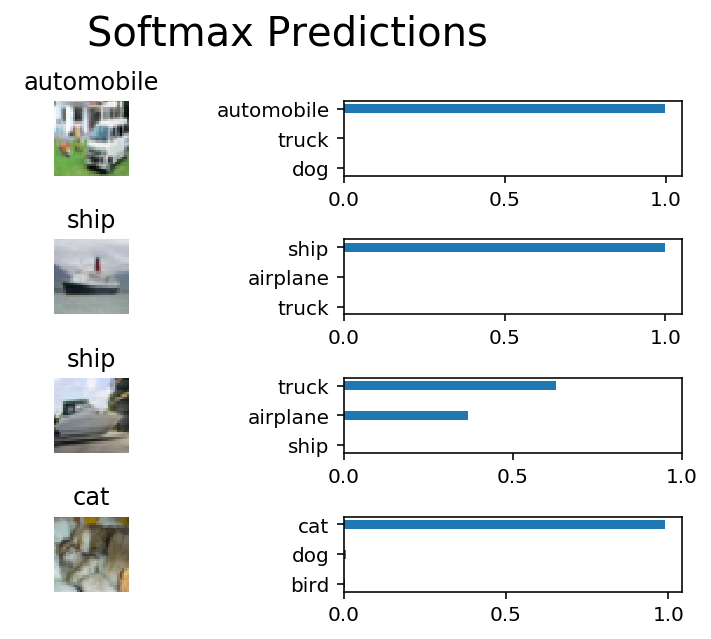

In [108]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Conclusion
We only got about 65% accuracy , which doesn't really seem all that great. First things first, This isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. That's because there are many more techniques that can be applied to the model.